# OSM Econ PS4
### Rebekah Dix

In [1]:
# import statements
import numpy as np
import scipy.optimize as opt
import scipy.stats as stats
from numba import vectorize, jit, njit, float64, prange
from collections import namedtuple
import pandas as pd

import sympy as sy
from sympy.solvers import solve

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from rouwen import rouwen
from LinApp_FindSS import LinApp_FindSS
from LinApp_Deriv import LinApp_Deriv
from LinApp_Solve import LinApp_Solve

# DSGE

## Exercises 1, 2, 3, 4

See problem set write-up.

## Exercise 5

In [2]:
# store parameters in a named tuple
params = ["a", "alpha", "beta", "delta", "gamma", "rho", "sigma", "tau", "xi", "zbar"]
BaselineModel = namedtuple("BaselineModel", params)

In [3]:
# set parameter values
m = BaselineModel(0.50, 0.40, 0.98, 0.10, 2.50, 0.95, 0.02, 0.05, 1.5, 0)

See problem set write-up for characterizing equations.

For this model we use the following functional forms:

\begin{align*}
  u(c_t) &= \frac{c_t^{1 - \gamma} - 1}{1 - \gamma} \\
  F(k_t, l_t, z_t) &= k_t^{\alpha} (l_t e^{z_t})^{1 - \alpha}
\end{align*}

Since there are no labor decisions, we can simplify the model greatly from Chase's example.

In [4]:
def euler_eqn(m, x):
    k = x
    l = 1
    r = m.alpha * ((np.exp(m.zbar) / k) ** (1 - m.alpha))
    w = (1 - m.alpha) * np.exp(m.zbar) * ((k / np.exp(m.zbar)) ** m.alpha)
    T = m.tau * (w + (r - m.delta)* k)
    c = (1 - m.tau) * (w + (r - m.delta)* k) + k + T - k
    euler = 1/(c ** m.gamma) - (m.beta / (c ** m.gamma)) * ((r - m.delta) * (1 - m.tau) + 1)
    return euler
    
def solve_ss(m):
    solve_me = lambda x: euler_eqn(m, x)
    sol = opt.root(solve_me, .5)
    
    return sol.x

In [5]:
kbar = solve_ss(m)
rbar = m.alpha * ((np.exp(m.zbar) / kbar) ** (1 - m.alpha))
wbar = (1 - m.alpha) * np.exp(m.zbar) * ((kbar / np.exp(m.zbar)) ** m.alpha)
Tbar = m.tau * (wbar + (rbar - m.delta)* kbar)
cbar = (1 - m.tau) * (wbar + (rbar - m.delta)* kbar) + Tbar

Ybar = kbar ** m.alpha * np.exp(m.zbar) ** (1 - m.alpha)
ibar = m.delta * kbar

SS_vals = {'Kbar': kbar, 'cbar': cbar, 
           'rbar': rbar, 'Tbar': Tbar, 'wbar': wbar,
           'Ybar': Ybar, 'ibar': ibar}

print(SS_vals)

{'Kbar': array([7.28749795]), 'cbar': array([1.48450482]), 'rbar': array([0.12148228]), 'Tbar': array([0.07422524]), 'wbar': array([1.32795277]), 'Ybar': array([2.21325461]), 'ibar': array([0.7287498])}


### Compare with algebraic solution

I derived the algebraic solution in my problem set write-up. Here, I compare the numerical values implies by the algebraic solution with the above calculation.

In [6]:
rbara = (1 - m.beta) / (m.beta * (1 - m.tau)) + m.delta
kbara = (rbara / m.alpha) ** (1 / (m.alpha - 1))
wbara = (1 - m.alpha) * (kbara) ** m.alpha
Tbara = m.tau * (wbara + (rbara - m.delta)* kbara)
cbara = (1 - m.tau) * (wbara + (rbara - m.delta)* kbara) + Tbara
Ybara = kbara ** m.alpha * np.exp(m.zbar) ** (1 - m.alpha)
ibara = m.delta * kbara

SS_vals_alg = {'Kbar': kbara, 'cbar': cbara, 
               'rbar': rbara, 'Tbar': Tbara, 'wbar': wbara,
               'Ybar': Ybara, 'ibar': ibara}

print(SS_vals_alg)

{'Kbar': 7.287497950692988, 'cbar': 1.484504818849544, 'rbar': 0.1214822771213749, 'Tbar': 0.0742252409424772, 'wbar': 1.3279527683513057, 'Ybar': 2.213254613918843, 'ibar': 0.7287497950692988}


Obbserve that the values found through the algebraic solution and the numerical solution are very similar.

## Exercise 6

See problem set write-up for characterizing equations.

\begin{align*}
  u(c_t, l_t) &= \frac{c_t^{1 - \gamma} - 1}{1 - \gamma} + a \frac{(1 - l_t)^{1 - \xi} - 1}{1 - \xi} \\
  F(k_t, l_t, z_t) &= k_t^{\alpha} (l_t e^{z_t})^{1 - \alpha}
\end{align*}

I closely mimic Chase's code in what follows.

In [7]:
def u(m, c, l):
    uc = (c**(1.0 - m.gamma) - 1.0) / (1.0 - m.gamma)
    ul = m.a * ((1.0 - l)**(1.0 - m.xi) - 1.0) / (1.0 - m.xi)
    return uc + ul

def du_dc(m, c, l):
    return c**(-m.gamma)

def du_dl(m, c, l):
    return - m.a * (1.0 - l)**(-m.xi)

def f(m, k, l, z):
    return k**m.alpha * (l * np.exp(z))**(1.0 - m.alpha)

def df_dk(m, k, l, z):
    return m.alpha * (l/k * np.exp(z))**(1.0 - m.alpha)

def df_dl(m, k, l, z):
    return (1.0 - m.alpha) * np.exp(z)**(1.0 - m.alpha) * (k / l)**m.alpha

In [8]:
def Definitions(m, ktp1, kt, lt, zt):
    wt = df_dl(m, kt, lt, zt)
    rt = df_dk(m, kt, lt, zt)
    Tt = m.tau * (wt*lt + (rt - m.delta)*kt)
    ct = (1 - m.tau) * (wt*lt + (rt - m.delta)*kt) + kt + Tt - ktp1

    ct = max(ct, 1e-8)

    return ct, rt, Tt, wt


def CharacteristicEquations(m, ktp2, ltp1, ktp1, lt, kt, ltm1, ztp1, zt):
    ct, rt, Tt, wt = Definitions(m, ktp1, kt, lt, zt)
    ctp1, rtp1, Ttp1, wtp1 = Definitions(m, ktp2, ktp1, ltp1, ztp1)
    rr_tp1 = (rtp1 - m.delta)*(1 - m.tau) + 1.0

    intertemporal_ee = du_dc(m, ct, lt) - m.beta*du_dc(m, ctp1, ltp1)*rr_tp1
    intratemporal_ee = du_dl(m, ct, lt) + du_dc(m, ct, lt)*wt*(1.0 - m.tau)

    return np.array([intertemporal_ee, intratemporal_ee])

In [9]:
def solve_ss(m):
    solve_me = lambda x: CharacteristicEquations(m, x[0], x[1], x[0], x[1], x[0], x[1], 0.0, 0.0)
    sol = opt.root(solve_me, np.array([0.5, 0.85]))

    return sol.x

In [10]:
kbar, lbar = solve_ss(m)
cbar, rbar, Tbar, wbar = Definitions(m, kbar, kbar, lbar, 0.0)
Ybar = kbar ** m.alpha * np.exp(m.zbar) ** (1 - m.alpha)
ibar = m.delta * kbar

SS_vals = {'Kbar': kbar, 'Lbar': lbar, 'cbar': cbar, 
           'rbar': rbar, 'Tbar': Tbar, 'wbar': wbar,
           'Ybar': Ybar, 'ibar': ibar}

print(SS_vals)

{'Kbar': 4.225229026815977, 'Lbar': 0.5797914531671479, 'cbar': 0.8607032061550788, 'rbar': 0.12148227712083877, 'Tbar': 0.04303516030775391, 'wbar': 1.3279527683552124, 'Ybar': 1.7796725500732373, 'ibar': 0.4225229026815977}


# Linearization Methods

## Exercise 1

#### Use analytical formulas to find values of matrices

From, the linearization notes, we have the following analytical formulas for the matrices in the model (however, in the notes, $\beta$ appears to be missing and a few other algebraic mistkes...):

In [11]:
A = m.alpha * m.beta
Kbar = A ** (1 / (1 - m.alpha))
N = m.rho
F = (m.alpha * m.beta * Kbar ** (m.alpha - 1)) / (Kbar ** m.alpha - Kbar)
# We express the rest of the matrices in terms of F
G = - F * (m.alpha + Kbar ** (m.alpha - 1))
H = F * m.alpha * (Kbar ** (m.alpha - 1))
L = - F * Kbar
M = F * (Kbar ** m.alpha)
# Which solution do we pick? 
P1 = (-G + np.sqrt(G ** 2 - 4 * F * H)) / (2 * F)
P2 = (-G - np.sqrt(G ** 2 - 4 * F * H)) / (2 * F)
Q1 = - (L*N + M) / (F*N + F*P1 + G)
Q2 = - (L*N + M) / (F*N + F*P2 + G)

Mats = {"F": F, "G": G, "H": L, "M": M, "N": N, "P": P2, "Q": Q2}
print(Mats)

{'F': 3.070711692755581, 'G': -9.061732872907285, 'H': -0.644736842105263, 'M': 1.6447368421052628, 'N': 0.95, 'P': 0.4, 'Q': 0.20996332662109748}


In [12]:
Kbar

0.20996332662109743

#### Plot the 3-D surface plot for the policy function $K' = H(K,z)$

The linearzied policy function is $K_{t+1} = \overline{K} + P(K_t + \overline{K}) + Q z_t$

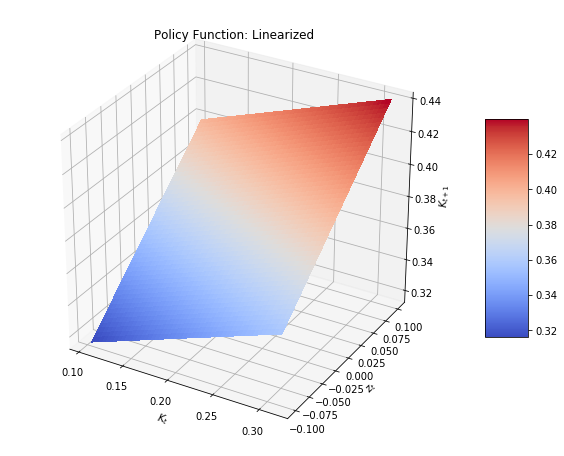

In [13]:
# Create grid for K
Kmax = 1.5 * Kbar
Kmin = 0.5 * Kbar
numPoints = 50
Kgrid = np.linspace(Kmax, Kmin, numPoints)

# Create grid for z
Zmin = -5 * m.sigma
Zmax = 5 * m.sigma
Zgrid = np.linspace(Zmax, Zmin, numPoints)

K, Z = np.meshgrid(Kgrid, Zgrid)

def policy_func_uhlig(K, Kbar, P, Q, z):
    return Kbar + P * (K + Kbar) + Q*z

policy1 = np.zeros((numPoints, numPoints))
for ii in range(numPoints):
    policy1[ii,:] = policy_func_uhlig(Kgrid[ii], Kbar, P2, Q2, Zgrid)

def policy_func(A, z, K, alpha):
    return A * np.exp(z) * K ** alpha

policy2 = np.zeros((numPoints, numPoints))
for ii in range(numPoints):
    policy2[ii,:] = policy_func(A, Zgrid, Kgrid[ii], m.alpha)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(K, Z, policy1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title('Policy Function: Linearized')
ax.set_xlabel(r'$K_t$')
ax.set_ylabel(r'$z_t$')
ax.set_zlabel(r'$K_{t+1}$')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

#### Compare with closed form solution

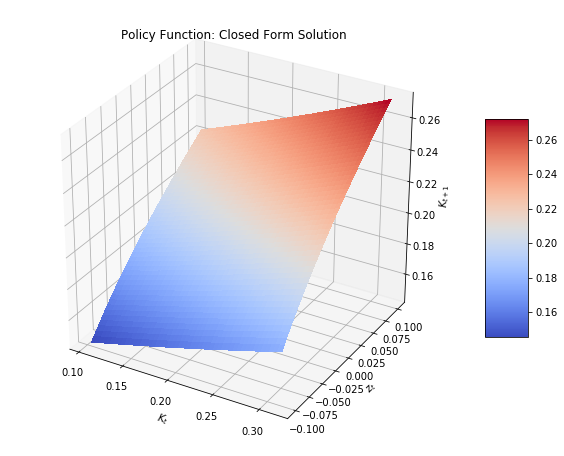

In [14]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(K, Z, policy2, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title('Policy Function: Closed Form Solution')
ax.set_xlabel(r'$K_t$')
ax.set_ylabel(r'$z_t$')
ax.set_zlabel(r'$K_{t+1}$')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

## Exercise 2

To solve this problem, I'll modify code from the DSGE_LinApp_OSM notebook. In order to use $\ln K$ as the endogenous state variable, we can exponentiate all instances of capital in the model, and then log-linearize the model.

In [15]:
def Modeldyn_2(theta, params):
    '''
    This function takes vectors of endogenous and exogenous state variables
    along with a vector of 'jump' variables and returns values from the
    characterizing Euler equations.
    
    Inputs are:
        theta: a vector containng (K2, K1, K, Zp, Z) where:
            K2: value of capital in two periods
            K1: value of capital in next period
            K: value of capital this period
            Z1: value of productivity in next period
            Z: value of productivity this period
        params: list of parameter values
    
    Output are:
        Euler: an Euler equations written so that they are zero at the
            steady state values of K & Z.   
    '''
    
    # unpack theta0
    (K2, K1, K, Z1, Z) = theta
    # unpack parameters
    alpha, beta = params
    
    # exponentiate variables
    K2 = np.exp(K2)
    K1 = np.exp(K1)
    K = np.exp(K)
    Z1 = np.exp(Z1)
    Z = np.exp(Z)
    
    # Evaluate Euler equations
    Eul = (beta * ((alpha * Z1 * K1 ** (alpha - 1)) * (Z * K ** alpha - K1))) / ((Z1 * K1 ** alpha - K2)) 
    
    return Eul

In [16]:
# make parameter list to pass to functions
alpha = .35
beta = .98
params = (alpha, beta)

# set LinApp parameters
Zbar = np.array([0.])
nx = 1
ny = 0
nz = 1
logX = 1
Sylv = 0

In [17]:
Kbar = (alpha * beta) ** (1.0 / (1 - alpha))
theta = np.array([Kbar, Kbar, Kbar, 0., 0.])

In [18]:
Kbar

0.1927826194504225

In [19]:
# find the derivatives matrices
[AA, BB, CC, DD, FF, GG, HH, JJ, KK, LL, MM, WW, TT] = \
    LinApp_Deriv(Modeldyn_2, params, theta, nx, ny, nz, logX)
print('FF: ', FF)
print('GG: ', GG)
print('HH: ', HH)
print('LL: ', LL)
print('MM: ', MM)

# set value for NN
rho = .95
NN = rho
    
# find the policy and jump function coefficients
PP, QQ, UU, RR, SS, VV = \
    LinApp_Solve(AA,BB,CC,DD,FF,GG,HH,JJ,KK,LL,MM,WW,TT,NN,Zbar,Sylv)
print ('PP:',PP)
print ('QQ:', QQ)

FF:  [[-0.38025431]]
GG:  [[0.46855868]]
HH:  [[-0.11741439]]
LL:  [[2.56932087]]
MM:  [[-2.26671785]]
PP: [[0.35]]
QQ: [[6.75684857]]


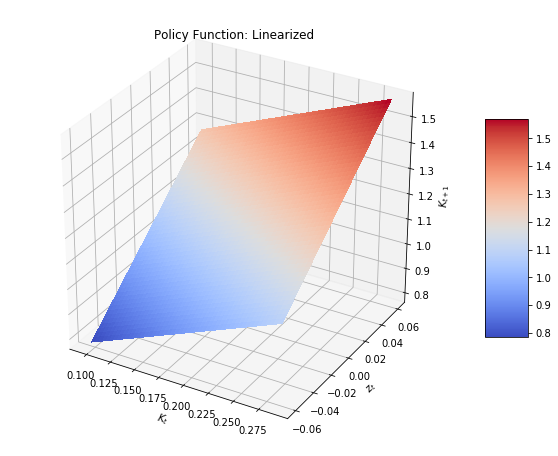

In [20]:
# Create grid for K
Kmax = 1.5 * Kbar
Kmin = 0.5 * Kbar
numPoints = 50
Kgrid = np.linspace(Kmax, Kmin, numPoints)

# Create grid for z
Zmin = -3 * m.sigma
Zmax = 3 * m.sigma
#pi, Zgrid = rouwen(m.rho, (Zmin + Zmax)/2, (Zmax - Zmin) / (numPoints - 1), numPoints)
Zgrid = np.linspace(Zmax, Zmin, numPoints)

K, Z = np.meshgrid(Kgrid, Zgrid)

def policy_func_uhlig_1(K, Kbar, P, Q, z):
    return Kbar + P * (K + Kbar) + Q*z

policy1 = np.zeros((numPoints, numPoints))
for ii in range(numPoints):
    policy1[ii,:] = policy_func_uhlig_1(Kgrid[ii], Kbar, P1, P1, Zgrid)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(K, Z, policy1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title('Policy Function: Linearized')
ax.set_xlabel(r'$K_t$')
ax.set_ylabel(r'$z_t$')
ax.set_zlabel(r'$K_{t+1}$')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

## Exercise 3

See problem set write-up.

## Exercise 4

In [21]:
# Parameters (for some reason, named tuples weren't passing well to functions.)
gamma = 2.5
xi = 1.5
beta = 0.98
alpha = 0.4
a = 0.5
delta = 0.10
z_bar = 0
rho_z = 0.9
tau = 0.05

params = gamma, xi, beta, alpha, a, delta, z_bar, tau

In [22]:
def Modeldefs(Xp, X, Y, Z, params):
    '''
    This function takes vectors of endogenous and exogenous state variables
    along with a vector of 'jump' variables and returns explicitly defined
    values for consumption, gdp, wages, real interest rates, and transfers
    
    Inputs are:
        Xp: value of capital in next period
        X: value of capital this period
        Y: value of labor this period
        Z: value of productivity this period
        params: list of parameter values
    
    Output are:
        Y: GDP
        w: wage rate
        r: rental rate on capital
        T: transfer payments
        c: consumption
        u: utiity
    '''
    
    # unpack input vectors
    kp = Xp
    k = X
    l = Y
    z = Z
    
    # unpack parameters
    gamma, xi, beta, alpha, a, delta, z_bar, tau = params
    
    # find definintion values 
    Y = (k ** alpha)*(((np.exp(z) * l)**(1 - alpha)))
    w = (1 - alpha)* np.exp(z) * ((k /( l * np.exp(z))) ** alpha)
    r = alpha *((l * np.exp(z) / k)**(1 - alpha))
    T = tau * (w * l + (r - delta) * k)
    c = (1 - tau) * (w * l +(r - delta) * k)+ k + T - kp
    u = (c ** (1 - gamma) - 1)/(1 - gamma) + a * (((1 - l) ** (1 - xi)) - 1)/(1 - xi)
    return Y, w, r, c, u

In [23]:
def Modeldyn(theta0, params):
    '''
    Inputs are:
        theta: a vector containng (Xpp, Xp, X, Yp, Y, Zp, Z) where:
            Xpp: value of capital in two periods
            Xp: value of capital in next period
            X: value of capital this period
            Yp: value of labor in next period
            Y: value of labor this period
            Zp: value of productivity in next period
            Z: value of productivity this period
        params: list of parameter values
    
    Output are:
        Euler: a vector of Euler equations written so that they are zero at the
            steady state values of X, Y & Z.  This is a 2x1 numpy array. 
    '''
    
    # unpack theta0
    (Xpp, Xp, X, Yp, Y, Zp, Z) = theta0
    l = Y #labor this period
    
    # unpack parameters
    gamma, xi, beta, alpha, a, delta, z_bar, tau = params
    
    # find definitions for now and next period
    Y, w, r, c, u = Modeldefs(Xp, X, Y, Z, params)
    Yp, wp, rp, cp, up = Modeldefs(Xpp, Xp, Yp, Zp, params)
    
    # Evaluate Euler equations
    E1 = (c**(-gamma))-beta*(cp**(-gamma))*((1-tau)*(rp-delta)+1)
    E2 = a*((1-l)**(-xi))-w*(1-tau)*(c**(-gamma))
    
    return np.array([E1, E2])

In [24]:
# set LinApp parameters
Zbar = np.array([z_bar])
nx = 1
ny = 1
nz = 1
logX = 0
Sylv = 0

In [25]:
# take a guess for steady state values of k and ell
guessXY = np.array([5, .3])

# find the steady state values using LinApp_FindSS
XYbar = LinApp_FindSS(Modeldyn, params, guessXY, Zbar, nx, ny)
(kbar, ellbar) = XYbar
print ('XYbar: ', XYbar)

# set up steady state input vector
theta0 = np.array([kbar, kbar, kbar, ellbar, ellbar, 0., 0.])

# check SS solution
check = Modeldyn(theta0, params)
print ('check: ', check)
if np.max(np.abs(check)) > 1.E-6:
    print ('Have NOT found steady state')
    
Ybar, wbar, rbar, cbar, ubar = Modeldefs(kbar, kbar, ellbar, 0, params)
Tbar, ibar = tau*cbar, delta*kbar
print ('Ybar: ', Ybar)
print ('wbar: ', wbar)
print ('rbar: ', rbar)
print ('cbar: ', cbar)
print ('ubar: ', ubar)
print ('Tbar: ', Tbar)
print ('ibar: ', ibar)

XYbar:  [4.22522903 0.57979145]
check:  [5.81756865e-14 1.23634436e-12]
Ybar:  1.283226108833101
wbar:  1.3279527683516184
rbar:  0.121482277121332
cbar:  0.8607032061543958
ubar:  -0.7108726381176589
Tbar:  0.04303516030771979
ibar:  0.42252290267870507


## Exercise 5

In [26]:
eps = 1e-5

steady_states = np.array(['kss', 'css', 'rss', 'wss', 'lss', 'Tss', 'yss', 'iss'])
parameters = np.array(['gamma', 'xi', 'beta', 'alpha', 'a', 'delta', 'z_bar', 'tau'])

Derivative_Mat = np.zeros((len(steady_states), len(parameters)))

params = np.array([gamma, xi, beta, alpha, a, delta, z_bar, tau])

for index, param in enumerate(params):
    # Find central difference
    paramplus1 = param + eps
    paramminus1 = param - eps
    params_plus1 = np.copy(params)
    params_minus1 = np.copy(params)
    params_plus1[index] = paramplus1
    params_minus1[index] = paramminus1

    if index == 6:
        Zbar1 = np.array([paramplus1])
        Zbar2 = np.array([paramminus1])
    else:
        Zbar1 = np.array([0])
        Zbar2 = np.array([0])
        
    XYbarplus1 = LinApp_FindSS(Modeldyn, params_plus1, guessXY, Zbar1, nx, ny)
    (kbarplus1, ellbarplus1) = XYbarplus1
    yplus1, wplus1, rplus1, cplus1, uplus1 = Modeldefs(kbarplus1, kbarplus1, ellbarplus1, 0, params_plus1)
    Tplus1, iplus1 = params_plus1[7]*cplus1, params_plus1[5]*kbarplus1
    
    XYbarminus1 = LinApp_FindSS(Modeldyn, params_minus1, guessXY, Zbar2, nx, ny)
    (kbarminus1, ellbarminus1) = XYbarminus1
    yminus1, wminus1, rminus1, cminus1, uminus1 = Modeldefs(kbarminus1, kbarminus1, ellbarminus1, 0, params_minus1)
    Tminus1, iminus1 = params_minus1[7]*cminus1, params_minus1[5]*kbarminus1

    vals = np.array([kbarplus1 - kbarminus1, cplus1 - cminus1,
                     rplus1 - rminus1, wplus1 - wminus1,
                     ellbarplus1 - ellbarminus1, Tplus1 - Tminus1,
                     yplus1 - yminus1, iplus1 - iminus1])
    
    Derivative_Mat[:, index] = vals / (2 * eps)

display_derivatives = pd.DataFrame(data = Derivative_Mat, index=steady_states, columns=parameters)
print(display_derivatives.round(decimals=4))

      gamma      xi     beta    alpha       a    delta   z_bar     tau
kss  0.1387 -0.8017  65.4304  25.9849 -1.8493 -48.3498  2.8383 -2.3232
css  0.0283 -0.1633   1.7511   2.0852 -0.3767  -3.5113 -0.1918 -0.2344
rss  0.0000  0.0000  -1.0960  -0.0000  0.0000   1.0000 -0.0729  0.0226
wss -0.0000  0.0000   7.9873   4.3959 -0.0000  -7.2875  0.5312 -0.1648
lss  0.0190 -0.1100   0.2602  -0.7694 -0.2538   1.3198 -0.1903 -0.1389
Tss  0.0014 -0.0082   0.0876   0.1043 -0.0188  -0.1756 -0.0096  0.8490
yss  0.0421 -0.2435   8.2941   4.6837 -0.5616  -4.1210  0.0921 -0.4667
iss  0.0139 -0.0802   6.5430   2.5985 -0.1849  -0.6098  0.2838 -0.2323


## Exercise 6

In [27]:
def Modeldyn_6(theta0, params):
    '''
    This function takes vectors of endogenous and exogenous state variables
    along with a vector of 'jump' variables and returns values from the
    characterizing Euler equations.
    
    Inputs are:
        theta: a vector containng (Xpp, Xp, X, Yp, Y, Zp, Z) where:
            Xpp: value of capital in two periods
            Xp: value of capital in next period
            X: value of capital this period
            Yp: value of labor in next period
            Y: value of labor this period
            Zp: value of productivity in next period
            Z: value of productivity this period
        params: list of parameter values
    
    Output are:
        Euler: a vector of Euler equations written so that they are zero at the
            steady state values of X, Y & Z.  This is a 2x1 numpy array. 
    '''
    
    # unpack theta0
    (Xpp, Xp, X, Yp, Y, Zp, Z) = theta0
    
    # unpack parameters
    gamma, xi, beta, alpha, a, delta, z_bar, tau = params
    
    # find definitions for now and next period
    Y, w, r, c, u = Modeldefs(Xp, X, Y, Z, params)
    Yp, wp, rp, cp, up = Modeldefs(Xpp, Xp, Yp, Zp, params)
    
    # Evaluate Euler equations
    ell = Y
    E1 = (c**(-gamma)*w) / (chi*ell**theta) - 1
    E2 = (c**(-gamma)) / (beta*cp**(-gamma)*(1 + rp - delta)) - 1
    
    return np.array([E1, E2])

def Modeldyn2(theta0, params):
    '''
    Inputs are:
        theta: a vector containng (Kpp, lp, Kp, l, K, lminus1, Zp, Z)
        params: list of parameter values
    
    Output are:
        Euler: a vector of Euler equations written so that they are zero at the
            steady state values of X, Y & Z.  This is a 2x1 numpy array. 
    '''
    
    # unpack theta0
    (Kpp, lp, Kp, l, K, lminus1, Zp, Z) = theta0
    
    # unpack parameters
    gamma, xi, beta, alpha, a, delta, z_bar, tau = params
    
    # find definitions for now and next period
    Y, w, r, c, u = Modeldefs(Kp, K, l, Z, params)
    Yp, wp, rp, cp, up = Modeldefs(Kpp, Kp, lp, Zp, params)
    
    # Evaluate Euler equations
    E1 = (c**(-gamma))-beta*(cp**(-gamma))*((1-tau)*(rp-delta)+1)
    E2 = a*((1-l)**(-xi))-w*(1-tau)*(c**(-gamma))
    
    return np.array([E1, E2])

In [28]:
nx = 2
ny = 0
nz = 1
logX = 1
Sylv = 0

# set up steady state input vector
theta0 = np.array([kbar, ellbar, kbar, ellbar, kbar, ellbar, 0., 0.])

# find the derivatives matrices
[AA, BB, CC, DD, FF, GG, HH, JJ, KK, LL, MM, WW, TT] = \
    LinApp_Deriv(Modeldyn2, params, theta0, nx, ny, nz, logX)
np.set_printoptions(suppress=False)
np.set_printoptions(precision=6)

print('FF: ', FF)
print('GG: ', GG)
print('HH: ', HH)
print('LL: ', LL)
print('MM: ', MM)

# set value for NN    
NN = rho_z
    
# find the policy and jump function coefficients
PP, QQ, UU, RR, SS, VV = \
    LinApp_Solve(AA,BB,CC,DD,FF,GG,HH,JJ,KK,LL,MM,WW,TT,NN,Zbar,Sylv)
print ('PP:',PP)
print ('QQ', QQ)

FF:  [[-17.856786   3.155187]
 [  0.         0.      ]]
GG:  [[ 36.195913  -3.253925]
 [-22.52732    8.63825 ]]
HH:  [[-18.24039    0.      ]
 [ 22.277027   0.      ]]
LL:  [[3.155187]
 [0.      ]]
MM:  [[-3.253925]
 [ 3.003659]]
PP: [[ 0.915294  0.      ]
 [-0.191927  0.      ]]
QQ [[ 0.128997]
 [-0.01131 ]]


## Exercise 7

In [29]:
# Parameters
gamma = 2.5
xi = 1.5
beta = 0.98
alpha = 0.4
a = 0.5
delta = 0.10
rho_z = 0.9
tau = 0.05
mu_z = 0
sigma_z = 0.02
numSims = 10000
numPeriods = 250

# Time-series for GDP, consumption, investment, and the labor input.
GDP = np.zeros((numSims, numPeriods))
consumption = np.zeros((numSims, numPeriods))
investment = np.zeros((numSims, numPeriods))
laborIn = np.zeros((numSims, numPeriods))

X_bar = np.array([[kbar],[ellbar]])
Z_bar = 0

for ii in range(numSims):
    # Store exogenous variable
    Z_tilde = np.zeros(numPeriods + 1)
    # Store endogenous variables: capital and labor
    X_tilde = np.zeros((2,numPeriods + 1))
    
    # Generate sequence of shocks
    eps = np.random.normal(loc=mu_z, scale=sigma_z, size=numPeriods)
    
    for tt in range(1, numPeriods + 1):
        # Update Z
        Z_tilde[tt] = NN * (Z_tilde[tt-1]) + eps[tt-1]
        # Get last period's X variables
        X_t_minus1 = np.array([X_tilde[:,tt-1]]).T
        # Update X
        X_tilde[:,tt] = (np.dot(PP, X_t_minus1) + QQ *(Z_tilde[tt])).T
    
    # Clear memory
    X = np.empty_like(X_tilde)
    Z = np.empty_like(Z_tilde)
    # Concert to actual levels
    X = X_bar * np.exp(X_tilde)
    Z = Z_tilde + Z_bar
    
    # Store variables
    # Capital today and tomorrow
    capital = X[0,:-1]
    capital1 = X[0,1:]
    # Labor
    laborIn[ii,:] = X[1, 1:]
    # Z
    shocks = Z[:-1]
    
    # GDP = Y
    GDP[ii,:] = (capital**alpha) * (((np.exp(shocks) * laborIn[ii,:])** (1 - alpha)))
    # Investment
    investment[ii,:] = capital1 - (1 - delta) * capital
    # Wage
    wage = (1-alpha) * np.exp(shocks) * ((capital / (laborIn[ii,:] * np.exp(shocks))) **alpha)
    # Rent
    rent = alpha * ((laborIn[ii,:] * np.exp(shocks) / capital) ** (1 - alpha))
    # Consumption
    consumption[ii,:] = (wage * laborIn[ii,:] + (rent - delta) * capital) + capital - capital1

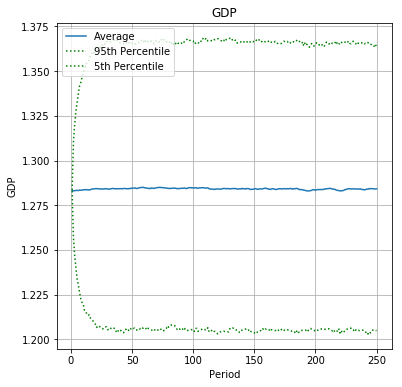

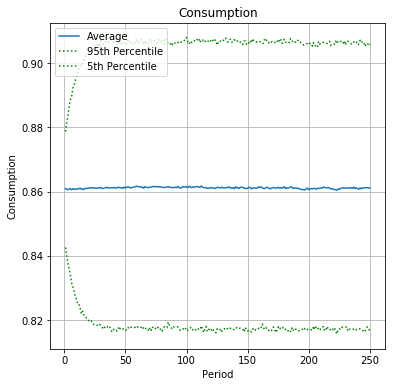

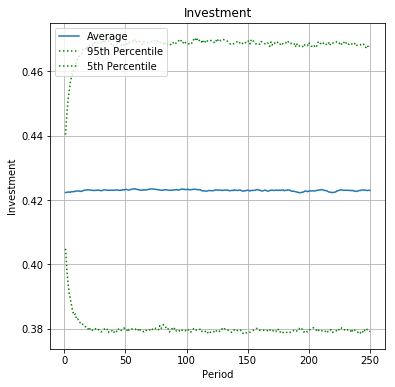

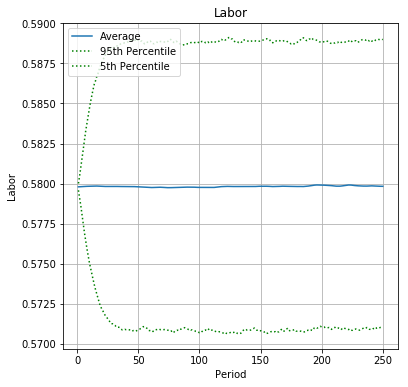

In [30]:
def plot_series(title, series):
    fig = plt.figure(figsize=(6,6))
    x = np.arange(1, 251, 1)
    q95 = np.percentile(series, 95, axis=0)
    q5 = np.percentile(series, 5, axis=0)
    av = np.mean(series, axis=0)
    plt.plot(x, av, label='Average')
    plt.plot(x, q95, 'g:', label='95th Percentile')
    plt.plot(x, q5, 'g:', label='5th Percentile')
    plt.xlabel('Period')
    plt.ylabel(title)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

plot_series('GDP', GDP)
plot_series('Consumption', consumption)
plot_series('Investment', investment)
plot_series('Labor', laborIn)

## Exercise 8

In [31]:
numSims = 10000
numPeriods = 250

means = np.empty((4,numSims))
volatility = np.empty((4,numSims))
coefvar = np.empty((4,numSims))
relvol = np.empty((4,numSims))
autocorrelation = np.empty((4,numSims))
cyclic = np.empty((4,numSims))
    
series = [GDP, consumption, investment, laborIn]

def autocorr(x, t=1):
    return np.corrcoef(np.array([x[0:len(x)-t], x[t:len(x)]]))

for index, s in enumerate(series):
    means[index, :] = np.mean(s)
    volatility[index, :] = np.std(s)
    coefvar[index, :] = means[index, :] / volatility[index, :]
    relvol[index, :] = volatility[index, :] / np.std(GDP)
    for index1 in range(numSims):
        tempSeries = pd.Series(s[index1, :])
        autocorrelation[index, index1] = tempSeries.autocorr(1)
        cyclic[index, index1] = stats.pearsonr(s[index1, :], GDP[index1, :])[0]

In [32]:
names = np.array(['GDP', 'Consumption', 'Investment', 'Labor'])
for index, name in enumerate(names):
    print(name)
    print('Mean = ', np.mean(means[index, :]), '\nStandard Error = ', stats.sem(means[index, :]))
    print('Volatility =  ', np.mean(volatility[index, :]), '\nStandard Error = ', stats.sem(volatility[index, :]))
    print('Coefficient of Variation = ', np.mean(coefvar[index, :]), '\nStandard Error = ', stats.sem(coefvar[index, :]))
    print('Relative Volatility = ', np.mean(relvol[index, :]), '\nStandard Error = ', stats.sem(relvol[index, :]))
    print('Persistence = ', np.mean(autocorrelation[index, :]), '\nStandard Error = ', stats.sem(autocorrelation[index, :]))
    print('Cyclicality = ', np.mean(cyclic[index, :]), '\nStandard Error = ', stats.sem(cyclic[index, :]))
    print('____________________________________________________________')
    print('\n')

GDP
Mean =  1.2841268814412332 
Standard Error =  0.0
Volatility =   0.04814946529619733 
Standard Error =  1.3878481749250888e-19
Coefficient of Variation =  26.669597960055626 
Standard Error =  0.0
Relative Volatility =  1.0 
Standard Error =  0.0
Persistence =  0.9253259917014395 
Standard Error =  0.00025680308477509824
Cyclicality =  1.0 
Standard Error =  0.0
____________________________________________________________


Consumption
Mean =  0.8611402209998578 
Standard Error =  2.220557079880142e-18
Volatility =   0.026657325989556172 
Standard Error =  0.0
Coefficient of Variation =  32.304073609529944 
Standard Error =  7.105782655616455e-17
Relative Volatility =  0.5536370097896286 
Standard Error =  1.110278539940071e-18
Persistence =  0.6485624156796872 
Standard Error =  0.0009518989170529311
Cyclicality =  0.8802622043306514 
Standard Error =  0.00027995037447860346
____________________________________________________________


Investment
Mean =  0.42298666044137434 
Stan

## Exercise 9

In [33]:
# Parameters
gamma = 2.5
xi = 1.5
beta = 0.98
alpha = 0.4
a = 0.5
delta = 0.10
rho_z = 0.9
tau = 0.05
mu_z = 0
sigma_z = 0.02
numPeriods = 50

X_bar = np.array([[kbar],[ellbar]])
Z_bar = 0

# Store exogenous variable
Z_tilde = np.zeros(numPeriods + 1)
# Store endogenous variables: capital and labor
X_tilde = np.zeros((2, numPeriods + 1))
# Generate sequence of shocks
#eps = np.random.normal(loc=mu_z, scale=sigma_z, size=numPeriods)
eps = np.zeros(numPeriods + 1)
#lag = 40
eps[0] = sigma_z
# Clear memory
X = np.empty_like(X_tilde)
Z = np.empty_like(Z_tilde)

for tt in range(1, numPeriods + 1):
    # Update Z
    Z_tilde[tt] = NN * (Z_tilde[tt-1]) + eps[tt-1]
    # Get last period's X variables
    X_t_minus1 = np.array([X_tilde[:,tt-1]]).T
    # Update X
    X_tilde[:,tt] = (np.dot(PP, X_t_minus1) + QQ *(Z_tilde[tt])).T

# Convert to actual levels
X = X_bar * np.exp(X_tilde)
Z = Z_tilde + Z_bar

# Store variables
# Capital today and tomorrow
capital = X[0,:-1]
capital1 = X[0,1:]
# Labor
laborIn = X[1, 1:]
# Z
shocks = Z[:-1]
# GDP = Y
GDP = (capital**alpha) * (((np.exp(shocks) * laborIn)** (1 - alpha)))
# Investment
investment = capital1 - (1 - delta) * capital
# Wage
wage = (1-alpha) * np.exp(shocks) * ((capital / (laborIn * np.exp(shocks))) ** alpha)
# Rent
rent = alpha * ((laborIn * np.exp(shocks) / capital) ** (1 - alpha))
# Consumption
consumption = (wage * laborIn + (rent - delta) * capital) + capital - capital1

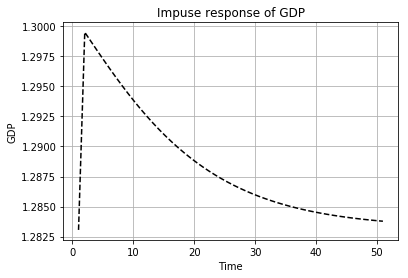

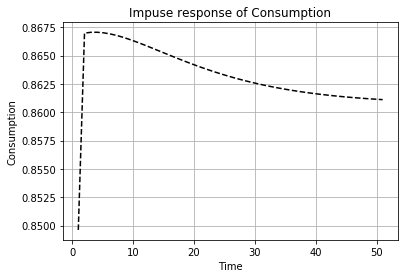

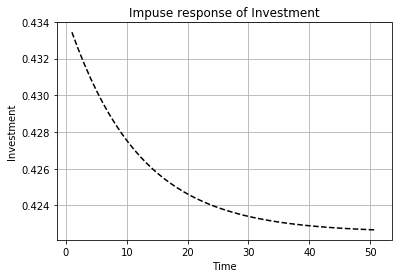

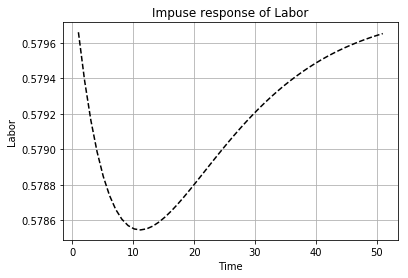

In [34]:
names = np.array(['GDP', 'Consumption', 'Investment', 'Labor'])
series = [GDP, consumption, investment, laborIn]

for index, s in enumerate(series):
    periods = np.linspace(1, numPeriods + 1, numPeriods)
    plt.plot(periods, s[:numPeriods], 'k--')
    plt.xlabel('Time')
    plt.ylabel(names[index])
    plt.title('Impuse response of %s' %names[index])
    plt.grid()
    plt.show()

## Exercise 10

In [35]:
# Parameters
alpha = .35
beta = .96 ** 20
delta = 1 - (1 - .05) ** 20
sigma = 3
A = 1
z_bar = 0
rho_z = 0.9 ** 20
nvec = np.array([1, 1, .2])
length = 3
T = 30

params = alpha, beta, delta, sigma, nvec, A

In [36]:
def get_w(K, Z , w_args):
    '''This function calculates the equilibrium wage given a level
    of aggregate capital and model parameters.'''
    A, alpha = w_args
    
    w = (1 - alpha) * A * np.exp(Z) * (((K) / (2.2)) ** alpha)
    
    return w

def get_r(K, Z, r_args):
    '''This function calculates the equilibrium interest rate given a level
    of aggregate capital and model parameters..'''
    A, alpha, delta = r_args
    
    r = alpha * A * np.exp(Z) * ((2.2 / (K)) ** (1 - alpha)) - delta
    
    return r

In [37]:
def Modeldyn_OG(theta0, params):
    '''
    This function takes vectors of endogenous and exogenous state variables
    along with a vector of 'jump' variables and returns values from the
    characterizing Euler equations.
    
    Inputs are:
        theta: a vector containng (k2pp, k3pp, k2p, k3p, k2, k3, Zp, Z) where:
        params: list of parameter values
    
    Output are:
        Euler: a vector of Euler equations written so that they are zero at the
            steady state values of X, Y & Z.  This is a 2x1 numpy array. 
    '''
    
    # unpack theta0
    (k2pp, k3pp, k2p, k3p, k2, k3, Zp, Z) = theta0
    
    # unpack parameters
    alpha, beta, delta, sigma, nvec, A = params
    w_args = A, alpha
    r_args = A, alpha, delta
    
    # Agg capital today
    K = k2 + k3
    # Agg capital tomorrow
    Kp = k2p + k3p
    
    r = get_r(K, Z, r_args)
    rp = get_r(Kp, Zp, r_args)
    
    w = get_w(K, Z, w_args)
    wp = get_w(Kp, Zp, w_args)
    
    # Calculate consumption in each period from budget constraints
    c1 = nvec[0] * w - k2p
    c2 = nvec[1] * w + (1 + r) * k2 - k3p
    c2p = nvec[1] * wp + (1 + rp) * k2p - k3pp
    c3p = (1 + rp) * k3p + nvec[2] * wp
    
    # Calculate marginal utilities
    MU1 = c1 ** (-sigma)
    MU2 = c2 ** (-sigma)
    MU2p = c2p ** (-sigma)
    MU3p = c3p ** (-sigma)
    
    # Calculuate errors from intertemporal Euler equations
    err1 = MU1 - beta * (1 + rp) * MU2p
    err2 = MU2 - beta * (1 + rp) * MU3p
    
    
    return np.array([err1, err2])

In [38]:
# set LinApp parameters
Zbar = np.array([z_bar])
nx = 2
ny = 0
nz = 1
logX = 1
Sylv = 0

In [39]:
# take a guess for steady state values of kbar2 and kbar3
guessXY = np.array([.05, .05])

# find the steady state values using LinApp_FindSS
XYbar = LinApp_FindSS(Modeldyn_OG, params, guessXY, Zbar, nx, ny)
(kbar2, kbar3) = XYbar
print ('XYbar: ', XYbar)

# set up steady state input vector
theta0 = np.array([kbar2, kbar3, kbar2, kbar3, kbar2, kbar3, 0., 0.])

# check SS solution
check = Modeldyn_OG(theta0, params)
print ('check: ', check)
if np.max(np.abs(check)) > 1.E-6:
    print ('Have NOT found steady state')
    
    
# find the derivatives matrices
[AA, BB, CC, DD, FF, GG, HH, JJ, KK, LL, MM, WW, TT] = \
    LinApp_Deriv(Modeldyn_OG, params, theta0, nx, ny, nz, logX)
print('FF: ', FF)
print('GG: ', GG)
print('HH: ', HH)
print('LL: ', LL)
print('MM: ', MM)

# set value for NN    
NN = rho_z
    
# find the policy and jump function coefficients
PP, QQ, UU, RR, SS, VV = \
    LinApp_Solve(AA,BB,CC,DD,FF,GG,HH,JJ,KK,LL,MM,WW,TT,NN,Zbar,Sylv)
print ('PP:',PP)
print ('QQ:', QQ)


XYbar:  [0.019313 0.058412]
check:  [ 5.022116e-11 -3.126388e-13]
FF:  [[   0.       -137.731705]
 [   0.          0.      ]]
GG:  [[251.248889 128.796947]
 [-18.773714 305.156579]]
HH:  [[ -47.535443 -143.771497]
 [-115.386662  -37.379759]]
LL:  [[468.118699]
 [200.173326]]
MM:  [[-546.591248]
 [-405.737093]]
PP: [[0.035306 0.63635 ]
 [0.380295 0.161643]]
QQ: [[1.846708]
 [1.363465]]


In [40]:
K_SS = np.array([[kbar2],[kbar3]])
K_tilde = np.zeros((2, T))
# Initial Conditions (need to convert to levels)
K_tilde[0,0] = np.log(0.8 * kbar2) - np.log(kbar2)
K_tilde[1,0] = np.log(1.1 * kbar3) - np.log(kbar3)

# Generate Agg Capital path
for tt in range(1, T):
    K_tilde[:,tt] = (PP @ K_tilde[:,tt-1])
K = K_SS * np.exp(K_tilde)
K_TPI = np.sum(K, axis=0)

# Generate wage and capital paths
w_args = A, alpha
r_args = A, alpha, delta
rpath = get_r(K_TPI, np.zeros(T), r_args)
wpath = get_w(K_TPI, np.zeros(T), w_args)

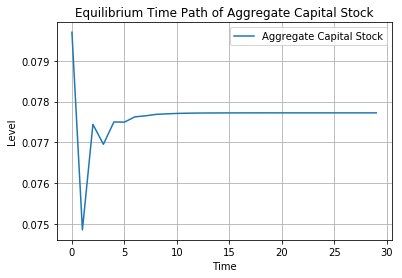

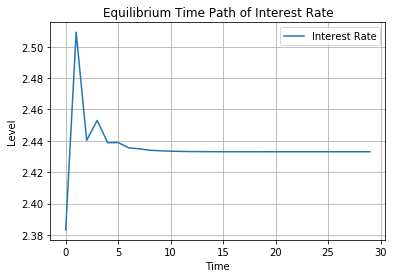

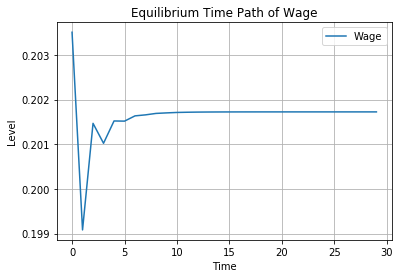

In [41]:
plt.plot(K_TPI, label='Aggregate Capital Stock')
plt.xlabel('Time')
plt.ylabel('Level')
plt.grid()
plt.title('Equilibrium Time Path of Aggregate Capital Stock')
plt.legend()
plt.show()

plt.plot(rpath, label='Interest Rate')
plt.xlabel('Time')
plt.ylabel('Level')
plt.grid()
plt.title('Equilibrium Time Path of Interest Rate')
plt.legend()
plt.show()

plt.plot(wpath, label='Wage')
plt.xlabel('Time')
plt.ylabel('Level')
plt.grid()
plt.title('Equilibrium Time Path of Wage')
plt.legend()
plt.show()

These results are nearly analogous to the results from using time path iteration. However, this linearization method appears to be much faster. Thus, we appear to lose little accuracy but gain speed with linearization methods.

## Exercise 11

In [42]:
# Parameters
gamma = 2.5
xi = 1.5
beta = 0.98
alpha = 0.4
a = 0.5
delta = 0.10
rho_z = 0.9 ** 20
tau = 0.05
mu_z = 0
sigma_z = 0.02
numSims = 10000
numPeriods = 250

# Time-series for GDP, consumption, investment, and the labor input.
GDP = np.zeros((numSims, numPeriods))
consumption = np.zeros((numSims, numPeriods))
investment = np.zeros((numSims, numPeriods))

X_bar = np.array([[kbar2],[kbar3]])
Z_bar = 0

for ii in range(numSims):
    # Store exogenous variable
    Z_tilde = np.zeros(numPeriods + 1)
    # Store endogenous variables: capital and labor
    X_tilde = np.zeros((2,numPeriods + 1))
    
    # Generate sequence of shocks
    eps = np.random.normal(loc=mu_z, scale=sigma_z, size=numPeriods)
    
    for tt in range(1, numPeriods + 1):
        # Update Z
        Z_tilde[tt] = NN * (Z_tilde[tt-1]) + eps[tt-1]
        # Get last period's X variables
        X_t_minus1 = np.array([X_tilde[:,tt-1]]).T
        # Update X
        X_tilde[:,tt] = (np.dot(PP, X_t_minus1) + QQ *(Z_tilde[tt])).T
    
    # Clear memory
    X = np.empty_like(X_tilde)
    Z = np.empty_like(Z_tilde)
    # Concert to actual levels
    X = X_bar * np.exp(X_tilde)
    Z = Z_tilde + Z_bar
    
    # Store variables
    # Capital today and tomorrow
    capital = X[0,:] + X[1,:]
    # Z
    shocks = Z[:-1]
    
    # GDP = Y
    GDP[ii,:] = A * (capital[1:]**alpha) * (((np.exp(shocks) * 2.2)** (1 - alpha)))
    # Investment
    investment[ii,:] = capital[1:] - (1 - delta) * capital[:-1]
    # Consumption
    consumption[ii,:] = GDP[ii,:] - investment[ii,:] 

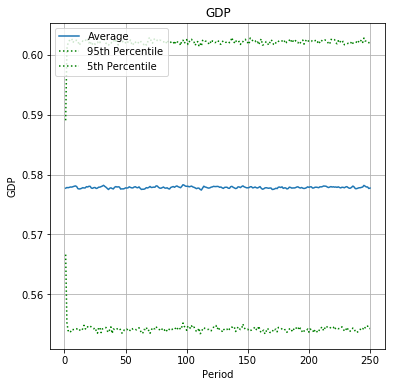

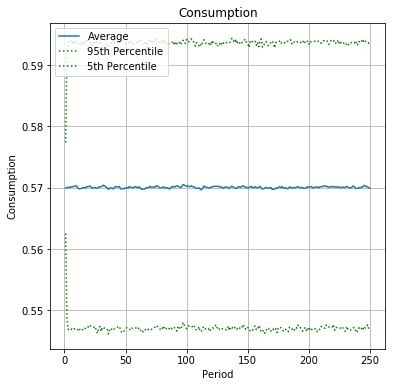

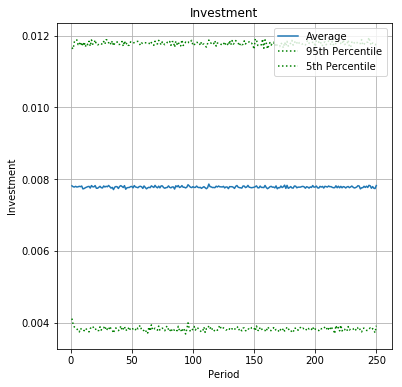

In [43]:
def plot_series(title, series):
    fig = plt.figure(figsize=(6,6))
    x = np.arange(1, 251, 1)
    q95 = np.percentile(series, 95, axis=0)
    q5 = np.percentile(series, 5, axis=0)
    av = np.mean(series, axis=0)
    plt.plot(x, av, label='Average')
    plt.plot(x, q95, 'g:', label='95th Percentile')
    plt.plot(x, q5, 'g:', label='5th Percentile')
    plt.xlabel('Period')
    plt.ylabel(title)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

plot_series('GDP', GDP)
plot_series('Consumption', consumption)
plot_series('Investment', investment)

# Perturbation Methods

## Exercise 1

See problem set write-up.

## Exercise 2

In [44]:
alpha = .33
z = 1
b = 2
t = .1
h = 24

In [45]:
def mkt_wage(w, *p):
    alpha, z, b, t, h, k = p
    nd = (((1 - alpha)* z) / w) ** (1 / alpha) * k
    pi = z * k ** alpha * (nd) ** (1 - alpha) - w * nd
    ns = h - (b / (w * (1 + b))) * (w * h + pi - t)
    return nd - ns

In [46]:
k = 5
params = alpha, z, b, t, h, k
equi_w = opt.fsolve(mkt_wage, 0.5, args=params)
equi_w

array([0.627362])

In [47]:
# Set up grid space between k=1 and k=15 
# and find equilibrium wage a each grid point
kGrid = np.arange(1, 16, 1)
wageGrid = np.zeros(len(kGrid))
for ii in range(len(kGrid)):
    params = alpha, z, b, t, h, kGrid[ii]
    wageGrid[ii] = opt.fsolve(mkt_wage, .1, args=params)

In [48]:
# First order approximation
def first_order_k(k, params, eps, wageGrid, kGrid):
    alpha, z, b, t, h, = params
    argsminus = alpha, z, b, t, h, (k - eps)
    argsplus = alpha, z, b, t, h, (k + eps)
    
    wminus = opt.fsolve(mkt_wage, 0.5, args=argsminus)
    wplus = opt.fsolve(mkt_wage, 0.5, args=argsplus)
    
    # Central difference
    xu = (wplus - wminus)/(2 * eps)
    wage_k = wageGrid[kGrid == k] + xu * (kGrid - k)

    return wage_k

In [49]:
params = alpha, z, b, t, h
eps = 1e-5

wage_5 = first_order_k(5, params, eps, wageGrid, kGrid)
wage_10 = first_order_k(10, params, eps, wageGrid, kGrid)

In [50]:
# Second order approximation
def second_order_k(k, params, eps, wageGrid, kGrid):
    
    alpha, z, b, t, h, = params
    argsminus = alpha, z, b, t, h, (k - eps)
    argsplus = alpha, z, b, t, h, (k + eps)
    args = alpha, z, b, t, h, k
    
    wminus = opt.fsolve(mkt_wage, 0.5, args=argsminus)
    wplus = opt.fsolve(mkt_wage, 0.5, args=argsplus)
    w = opt.fsolve(mkt_wage, 0.5, args=args)
        
    xu = (wplus - wminus)/(2 * eps)
    # Use forward and backward differences to get second derivative
    xuu = (wplus - 2 * w + wminus) / (eps ** 2)
     
    wage_k = wageGrid[kGrid == k] + xu * (kGrid - k) + 0.5 * xuu * (kGrid - k) ** 2
    
    return wage_k

In [51]:
params = alpha, z, b, t, h
eps = 1e-5

wage_5_second = second_order_k(5, params, eps, wageGrid, kGrid)
wage_10_second = second_order_k(10, params, eps, wageGrid, kGrid)

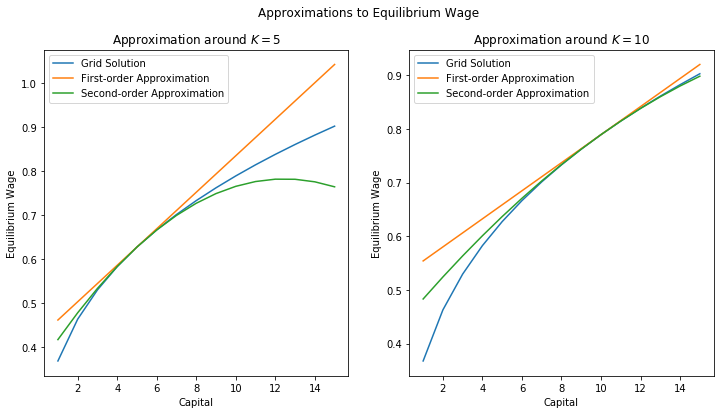

In [52]:
# Plot the grid solution, the linear and quadratic approximations on the same graph
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot(kGrid, wageGrid, label='Grid Solution')
ax[0].plot(kGrid, wage_5, label='First-order Approximation')
ax[0].plot(kGrid, wage_5_second, label='Second-order Approximation')
ax[0].set_xlabel('Capital')
ax[0].set_ylabel('Equilibrium Wage')
ax[0].legend()
ax[0].set_title(r'Approximation around $K=5$')

ax[1].plot(kGrid, wageGrid, label='Grid Solution')
ax[1].plot(kGrid, wage_10, label='First-order Approximation')
ax[1].plot(kGrid, wage_10_second, label='Second-order Approximation')
ax[1].set_xlabel('Capital')
ax[1].set_ylabel('Equilibrium Wage')
ax[1].legend()
ax[1].set_title(r'Approximation around $K=10$')

plt.suptitle('Approximations to Equilibrium Wage')
plt.show()

## Exercise 3

$F(y,x) = (x^{.35} + .9x - y)^{-2.5} - .95(y^{.35} + .9y)^{-2.5} = 0$

We ﬁnd the cubic approximation of $y = G(x)$ about the point $x_0 = 100$. 

In [53]:
# Set up a grid on the space between x = 99 and x = 101.
xGrid = np.linspace(99, 101, 50)

In [54]:
# Define function
def Func(y, *x):
    x = x[0]
    return (x ** .35 + .9 * x - y) ** -2.5 - .95 * (y **.35 + .9 * y) ** -2.5

In [55]:
eps = .01
xzero = 100

# Calculate differences
xplus1 = opt.fsolve(Func, 50, args=xzero + eps)
xminus1 = opt.fsolve(Func, 50, args=xzero - eps)
xplus2 = opt.fsolve(Func, 50, args=xzero + 2 * eps)
xminus2 = opt.fsolve(Func, 50, args=xzero - 2 * eps)
xcenter = opt.fsolve(Func, 50, args=xzero)
xu = (xplus1 - xminus1) / (2 * eps)
xuu = (xplus1 - 2 * xcenter + xminus1) / (eps ** 2)
xuuu = (xplus2 - 2 * xplus1 + 2 * xminus1  - xminus2) / (2 * eps ** 3)

# Approximations
linear = xcenter + xu * (xGrid - xzero)
quad = xcenter + xu * (xGrid - xzero) + (.5) * xuu * (xGrid - xzero) ** 2
cubic = xcenter + xu * (xGrid - xzero) + (.5) * xuu * (xGrid - xzero) ** 2 + (1.0/6) * xuuu * (xGrid - xzero) ** 3

# Grid solution
gridSol = np.zeros(len(xGrid))
for ii in range(len(xGrid)):
    gridSol[ii] = opt.fsolve(Func, 50, args=xGrid[ii])  

In [56]:
xu

array([0.471085])

In [57]:
xuu * .5

array([-6.597212e-06])

In [58]:
xuuu * (1/6)

array([3.611926e-08])

Functional form of this polynomial with numbers for coeﬃcients:

$$f(x) = 47.466 + .471 ( x - x_0) - 6.597 \times 10^{-6} (x - x_0)^2 + 3.612 \times 10^{-8} (x - x_0)^3$$

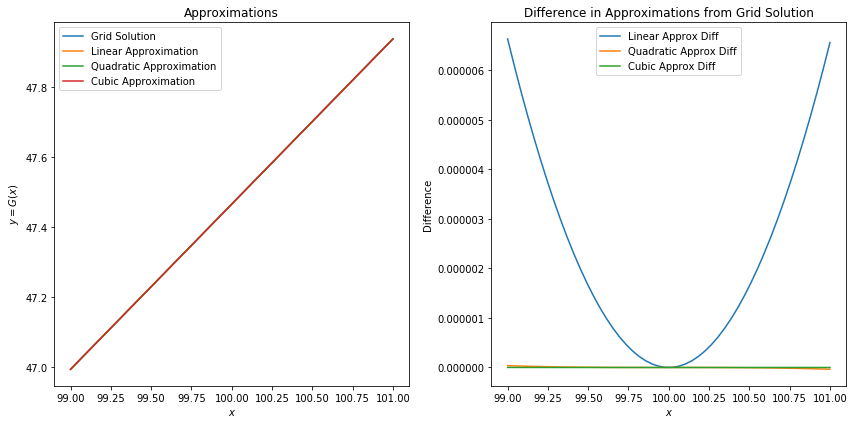

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
# Plot approximations
ax[0].plot(xGrid, gridSol, label='Grid Solution')
ax[0].plot(xGrid, linear, label='Linear Approximation')
ax[0].plot(xGrid, quad, label='Quadratic Approximation')
ax[0].plot(xGrid, cubic, label='Cubic Approximation')
ax[0].legend()
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$y = G(x)$')
ax[0].set_title('Approximations')

# Plot the difference between the linear, quadratic and cubic approximations and the grid solution
ax[1].plot(xGrid, linear - gridSol, label='Linear Approx Diff')
ax[1].plot(xGrid, quad - gridSol, label='Quadratic Approx Diff')
ax[1].plot(xGrid, cubic - gridSol, label='Cubic Approx Diff')
ax[1].legend()
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'Difference')
ax[1].set_title('Difference in Approximations from Grid Solution')

plt.tight_layout()
plt.show()

## Exercise 4

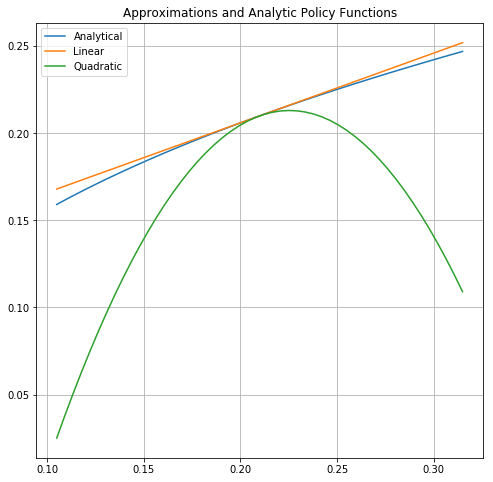

In [60]:
# SS capital
kbar = (m.alpha * m.beta) ** (1 / (1 - m.alpha))

# We'll use sympy to find analytical derivatives
# Symbols:
u = sy.Symbol('u') # K_t
x = sy.Function('x')(u) # x is a function of u, K_{t+1}
y = sy.Function('y')(u) # y is a functino of u, K_{t+2}
xu = sy.Symbol('xu') 
xuu = sy.Symbol('xuu')

# Euler Equation
F = (1 / (u ** m.alpha - x)) - ((m.beta * m.alpha * x ** (m.alpha - 1)) / (x ** m.alpha - y))

dFu = sy.diff(F, u)
# Subsitute in xu and xuu for derivatives of x and y and evaluate at steady state
dFuSubs = dFu.subs([(sy.diff(x, u), xu), (sy.diff(y, u), xu ** 2), (y, kbar), (x, kbar), (u, kbar)])

# Solve for x_u and x_uu
xu = float(solve(dFuSubs)[0])

dFuu = sy.diff(F, u, 2)
# Subsitute in xu and xuu for derivatives of x and y and evaluate at steady state
dFuuSubs = dFuu.subs([(sy.diff(y, u, 2), (xu + xu ** 2) * xuu), (sy.diff(x, u, 2), xuu), 
                      (sy.diff(y, u), xu ** 2), (sy.diff(x, u), xu), 
                      (y, kbar), (x, kbar), (u, kbar)])

xuu = float(solve(dFuuSubs)[0])

#Policy functions:
def analytic(m, k):
    return m.alpha * m.beta * (k ** m.alpha)

def linear(k, kbar, xu):
    return kbar + kbar * xu * ((k - kbar) / kbar) 

def quadratic(k, kbar, xu, xuu):
    return kbar + kbar * xu * ((k - kbar) / kbar) + 0.5 * xuu * ((k - kbar) / kbar) ** 2 

# Create Capital Grid
kGrid = np.linspace(0.5 * kbar, 1.5 * kbar, 50)

# Plot policy functions
fig = plt.figure(figsize=(8, 8))
plt.plot(kGrid, analytic(m, kGrid), label='Analytical')
plt.plot(kGrid, linear(kGrid, kbar, xu), label='Linear')
plt.plot(kGrid, quadratic(kGrid, kbar, xu, xuu), label='Quadratic')
plt.grid()
plt.title('Approximations and Analytic Policy Functions')
plt.legend()
plt.show()

## Exercise 5 [[Incomplete]]

No dolo -- couldn't get code to compile so this problem is incomplete.

In [61]:
# SS capital
kbar = (m.alpha * m.beta) ** (1 / (1 - m.alpha))

# We'll use sympy to find analytical derivatives
# Symbols:
u = sy.Symbol('u') # K_t
x = sy.Function('x')(u) # x is a function of u, K_{t+1}
y = sy.Function('y')(u) # y is a functino of u, K_{t+2}
xu = sy.Symbol('xu') 
xuu = sy.Symbol('xuu')

# Euler Equation
F = (1 / (u ** m.alpha - x)) - ((m.beta * m.alpha * x ** (m.alpha - 1)) / (x ** m.alpha - y))

dFu = sy.diff(F, u)
# Subsitute in xu and xuu for derivatives of x and y and evaluate at steady state
dFuSubs = dFu.subs([(sy.diff(x, u), xu), (sy.diff(y, u), xu ** 2), (y, kbar), (x, kbar), (u, kbar)])

# Solve for x_u and x_uu
xu = float(solve(dFuSubs)[0])

dFuu = sy.diff(F, u, 2)
# Subsitute in xu and xuu for derivatives of x and y and evaluate at steady state
dFuuSubs = dFuu.subs([(sy.diff(y, u, 2), (xu + xu ** 2) * xuu), (sy.diff(x, u, 2), xuu), 
                      (sy.diff(y, u), xu ** 2), (sy.diff(x, u), xu), 
                      (y, kbar), (x, kbar), (u, kbar)])

xuu = float(solve(dFuuSubs)[0])